# And yes, you can get dataset on ypur own :)

# Dataset creation 

First lets import all packages we will need

In [81]:
import os, glob
import random
import numpy as np
import copy
import shutil
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

## Step 1  Downloading images from google images

Make path for current data folder and for destination folder

## Step 2 Clean the data

Remove all non .jpg images

There need to be code, that removes all .png etc images from raw data

In [102]:
folder = './data/'
for class_name in os.listdir(folder):
    images = os.listdir(folder+class_name)
    for im in images:
        image_path = folder+class_name+'/'+im
        if not im[-4:]=='.jpg':
            print('Not .jpg file: {}'.format(im) + ' is not valid, deleting!')
            os.remove(image_path)
        else:
            try:
                Image.open(image_path)
            except:
                print('Image: {}'.format(im) + ' is not valid, deleting!')
                os.remove(image_path)
                

Make dictionary with mapping from class names to indexes

In [105]:
class_mapping = {}
for name in os.listdir(folder):
    class_mapping[name] = len(class_mapping)
print(class_mapping)

{'moderndancer': 2, 'ballerinaintutu': 3, 'ballerinainlongtulle': 0, 'womanineveningdress': 1}


## Step 3 Split to train/validation and form a propper folder structure

In [14]:
from_folder = './data/'
to_folder = './dataset/'

In [15]:
folders = os.listdir(from_folder)

In [16]:
folders

['ballerinainlongtulle',
 'womanineveningdress',
 'moderndancer',
 'ballerinaintutu']

In [17]:
def split(indexes, train_fraction=0.9):
    ''' 
    Splits indexes into train and validation part according to specified fraction.
    '''
    ind = copy.deepcopy(indexes)
    p = round(len(indexes)*train_fraction)
    np.random.shuffle(ind)
    return [ind[:p], ind[p:]]

In [18]:
def split_and_copy(from_folder, to_folder, train_fraction = 0.9):
    ''' 
    Move and rename downloaded images into train/ and validation/ directories. 
    Split according to train_fraction. 
    '''
    folders = os.listdir(from_folder)
    
    for ind, folder in enumerate(folders):
        images = os.listdir(from_folder+folder)
        indexes = list(range(len(images)))
        train_indexes, validation_indexes = split(indexes, train_fraction)
        
        # Check if directories exist and delete all the files in them if not.
        dest_train_folder = to_folder+'train/'+folder
        dest_validation_folder = to_folder+'validation/'+folder
        
        if not os.path.exists(dest_train_folder):
            os.makedirs(dest_train_folder)
        
        if not os.path.exists(dest_validation_folder):
            os.makedirs(dest_validation_folder)
            
        try:
            glob.glob(dest_train_folder+'/*')
            shutil.rmtree(dest_train_folder+'/*')
        except:
            pass
        
        try:
            glob.glob(dest_validation_folder+'/*')
            shutil.rmtree(dest_validation_folder+'/*')
        except:
            pass
        
        for i, image in enumerate([images[i] for i in train_indexes]):
            from_path = from_folder+folder+'/'+image
            to_path = dest_train_folder+'/'+'im'+str(i).zfill(3)+'.jpg'
            shutil.copy(from_path, to_path)
            
        for i, image in enumerate([images[i] for i in validation_indexes]):
            from_path = from_folder+folder+'/'+image
            to_path = dest_validation_folder+'/'+'im'+str(i).zfill(3)+'.jpg'
            shutil.copy(from_path, to_path)


In [19]:
split_and_copy(from_folder, to_folder, train_fraction=0.9)

## Step 4 Deal with image augmentation

./data/ballerinaintutu/ballerinaintutu_55.jpg


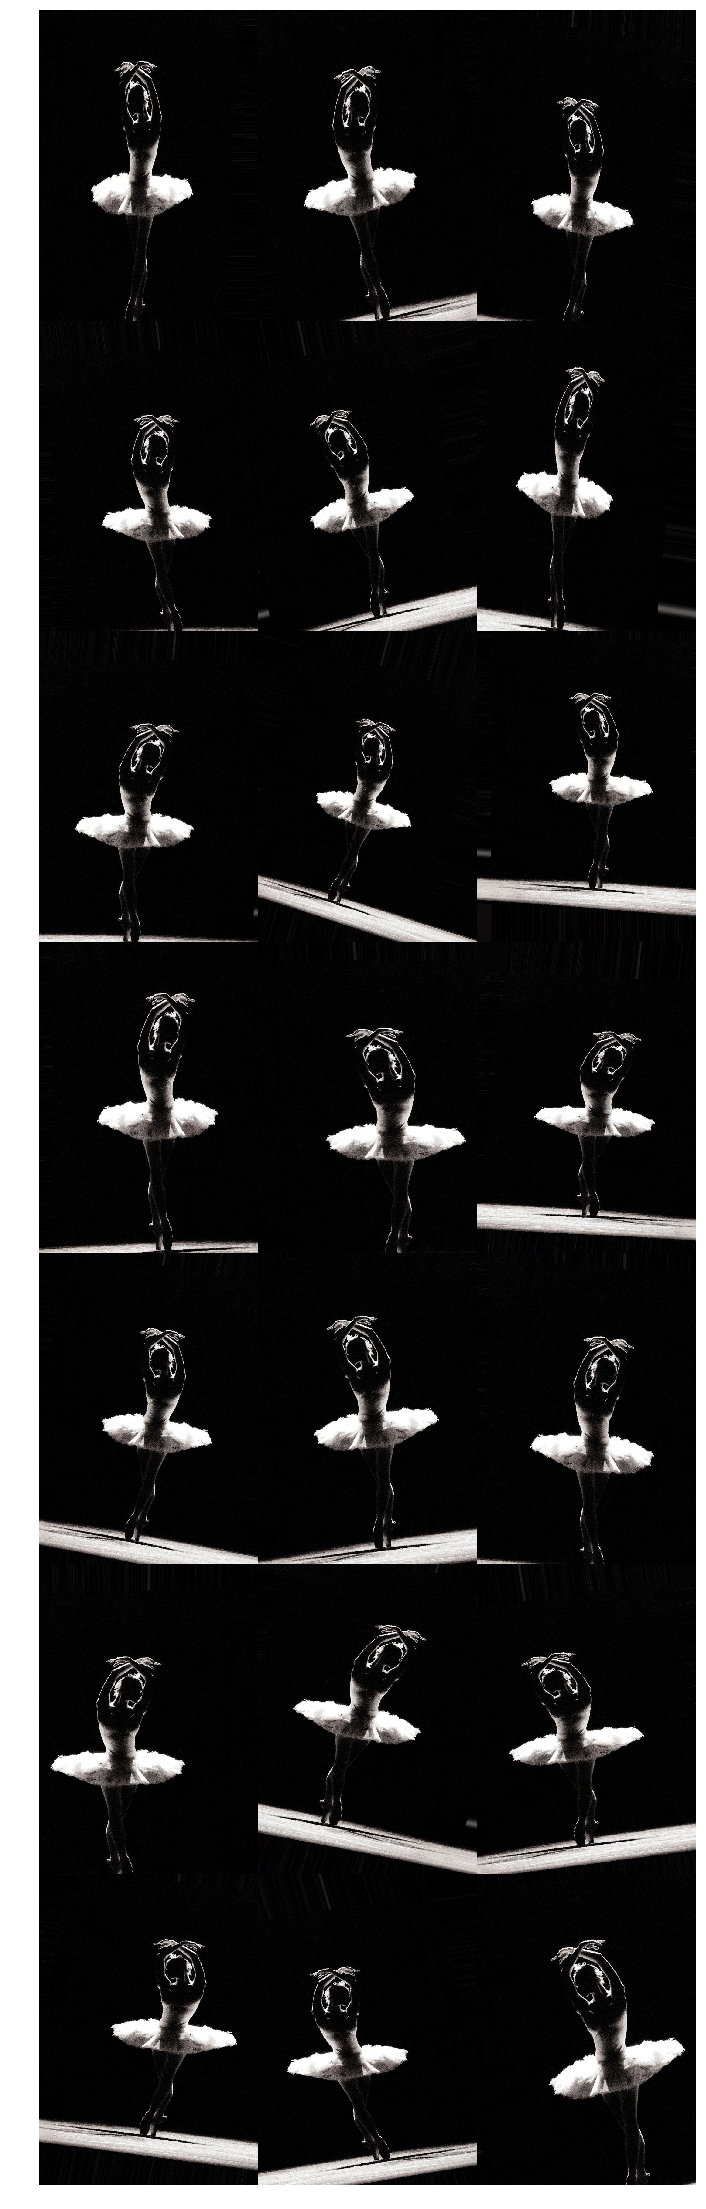

In [69]:
# Clean the priview directory
preview_folder = './augmentation_preview'

try:
    shutil.rmtree(preview_folder)
    os.makedirs(preview_folder)
except:
    os.makedirs(preview_folder)
    
# Produce 20 examples of data augmentation
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

data_folder = './data/'+random.choice(os.listdir('./data/'))
image_path = data_folder+'/'+random.choice(os.listdir(data_folder))
print(image_path)

img = load_img(image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=preview_folder, save_prefix='im', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
# Plot examples
def gallery(array, ncols=3):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape((nrows, ncols, height, width, intensity))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols, intensity)))
    return result

im_array = []

for image in os.listdir(preview_folder):
    image_path = preview_folder+'/'+image
    im = np.asarray(Image.open(image_path))
    im_array.append(im)

plt.figure(figsize=(40, 40))
plt.axis('off')
plt.imshow(gallery(np.array(im_array)))
plt.show()

## Step 5 Train classifier

In [118]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from confusion_matrix import plot_confusion_matrix
from plot_history import plot

### Training convnet from scratch

In [125]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [126]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './dataset/train',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

Found 1306 images belonging to 4 classes.
Found 145 images belonging to 4 classes.


In [127]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

model.save_weights('./weights/first_try.h5')  # always save your weights after training or during training

Epoch 1/50
125/125 [==============================] - 56s - loss: 1.1625 - acc: 0.4877 - val_loss: 1.0257 - val_acc: 0.5793
Epoch 2/50
125/125 [==============================] - 52s - loss: 1.0396 - acc: 0.5683 - val_loss: 0.9680 - val_acc: 0.6110
Epoch 3/50
125/125 [==============================] - 52s - loss: 0.9244 - acc: 0.6388 - val_loss: 0.9239 - val_acc: 0.5972
Epoch 4/50
125/125 [==============================] - 51s - loss: 0.8635 - acc: 0.6593 - val_loss: 0.9379 - val_acc: 0.6510
Epoch 5/50
125/125 [==============================] - 53s - loss: 0.7780 - acc: 0.6866 - val_loss: 0.8143 - val_acc: 0.6455
Epoch 6/50
125/125 [==============================] - 51s - loss: 0.7399 - acc: 0.7046 - val_loss: 0.8870 - val_acc: 0.6717
Epoch 7/50
125/125 [==============================] - 51s - loss: 0.7209 - acc: 0.7141 - val_loss: 0.8851 - val_acc: 0.6717
Epoch 8/50
125/125 [==============================] - 52s - loss: 0.6795 - acc: 0.7376 - val_loss: 0.8394 - val_acc: 0.6772
Epoch 9/

Lets plot train and validation accuracy

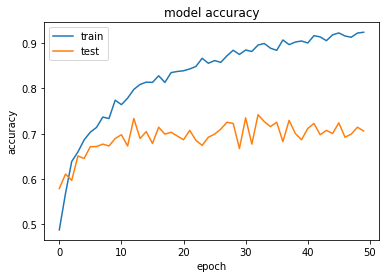

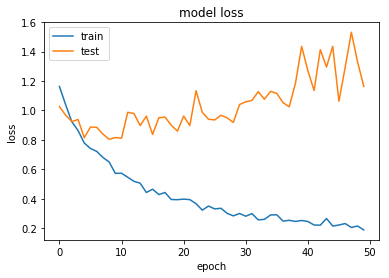

In [128]:
plot(history)

Lets plot confusion matrix

Found 145 images belonging to 4 classes.
Confusion matrix, without normalization
[[46  2  9  6]
 [ 6  1  2  1]
 [ 8  2 30  0]
 [ 3  0  4 25]]


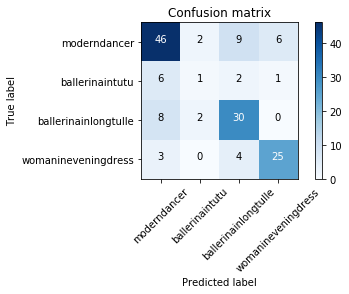

In [133]:
test_gen = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        seed=0,
        shuffle=False)

mapping = test_gen.class_indices
preds = [np.argmax(i) for i in model.predict_generator(test_gen, 10)]
labels = [mapping[f.split('/')[0]] for f in test_gen.filenames]
plot_confusion_matrix(labels, preds, classes = list(class_mapping.keys()))

### Using pretrained neural network as feature provider

In [120]:
batch_size = 16

generator = datagen.flow_from_directory(
        './dataset/train',
        target_size=(224, 150),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 2000)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 800)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train'

In [ ]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 400 + [1] * 400)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

### Training only dence layers with data augmentation

In [122]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

ValueError: Input 0 is incompatible with layer flatten_5: expected min_ndim=3, found ndim=2

In [123]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

NameError: name 'optimizers' is not defined

In [124]:
batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

# fine-tune the model
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

NameError: name 'train_data_dir' is not defined

### Finetuning dence and convolutional layers

# Interractive demo